Notes from [Complete Guide To The Futures Market](https://www.amazon.com/Complete-Guide-Futures-Market-Fundamental/dp/111885375X) by Schwager and Etzkorn

In [6]:
import xarray as xr
import quandl as ql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

1. Context indicators
    - Trend Lines
    - Internal Trend Lines
    - Trading Ranges and Trading Range breakouts
    - TD Lines
    - Prior Highs and Lows
    - Concentration of Relative Highs and Lows
    - Price Envelope Bands
    - Moving Averages

In [71]:
gold = ql.get('WGC/GOLD_DAILY_USD', start_date='01/01/2011')

## _Trend Lines_

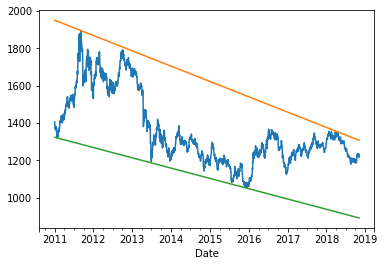

In [22]:
from scipy.stats import linregress

# get AAPL 10 years data

#data = qdl.get("WIKI/AAPL", start_date="2007-01-01", end_date="2017-05-01")

data = gold
data0 = data.copy()
data0['date_id'] = ((data0.index.date - data0.index.date.min())).astype('timedelta64[D]')
data0['date_id'] = data0['date_id'].dt.days + 1

# high trend line

data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['Value'],
                    )
    data1 = data1.loc[data1['Value'] > reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['Value'],
                    )

data0['high_trend'] = reg[0] * data0['date_id'] + reg[1]

# low trend line

data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['Value'],
                    )
    data1 = data1.loc[data1['Value'] < reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['Value'],
                    )

data0['low_trend'] = reg[0] * data0['date_id'] + reg[1]

# plot

data0['Value'].plot()
data0['high_trend'].plot()
data0['low_trend'].plot()

In [23]:
data0.head()

,Value,date_id,high_trend,low_trend
Date,,,,
2011-01-03,1405.5,1,1950.344909,1322.778027
2011-01-04,1388.5,2,1950.119930,1322.626906
2011-01-05,1368.0,3,1949.894950,1322.475785
2011-01-06,1368.5,4,1949.669971,1322.324664
2011-01-07,1367.0,5,1949.444992,1322.173543




## _Internal Trend Lines_

In [34]:
#If trendlines are drawn to capture extremes, 
#Internal Trend Lines are drawn to filter the extremes out.
#The argument is that extreme highs and lows are emotional excesses. 
#Internal Trend lines capture a majority of relative highd and lows. 

In [35]:
#Code taken from here
#https://github.com/dysonance/Trendy/blob/master/trendy.py
def gentrends(x, window=1/3., charts=True):
    """
    Returns a Pandas dataframe with support and resistance lines.
    :param x: One-dimensional data set
    :param window: How long the trendlines should be. If window < 1, then it
                   will be taken as a percentage of the size of the data
    :param charts: Boolean value saying whether to print chart to screen
    """

    import numpy as np
    #import pandas.io.data as pd

    x = np.array(x)

    if window < 1:
        window = int(window * len(x)) # evaluate the first portion of time series

    max1 = np.where(x == max(x))[0][0]  # find the index of the abs max
    min1 = np.where(x == min(x))[0][0]  # find the index of the abs min

    # First the max
    if max1 + window > len(x):
        max2 = max(x[0:(max1 - window)])#find max2 between index of abs_max and zeroth index in time-series
    else:
        max2 = max(x[(max1 + window):])

    # Now the min
    if min1 - window < 0:
        min2 = min(x[(min1 + window):])
    else:
        min2 = min(x[0:(min1 - window)])

    # Now find the indices of the secondary extrema
    max2 = np.where(x == max2)[0][0]  # find the index of the 2nd max
    min2 = np.where(x == min2)[0][0]  # find the index of the 2nd min

    # Create & extend the lines
    maxslope = (x[max1] - x[max2]) / (max1 - max2)  # slope between max points
    minslope = (x[min1] - x[min2]) / (min1 - min2)  # slope between min points
    a_max = x[max1] - (maxslope * max1)  # y-intercept for max trendline
    a_min = x[min1] - (minslope * min1)  # y-intercept for min trendline
    b_max = x[max1] + (maxslope * (len(x) - max1))  # extend to last data pt
    b_min = x[min1] + (minslope * (len(x) - min1))  # extend to last data point
    maxline = np.linspace(a_max, b_max, len(x))  # Y values between max's
    minline = np.linspace(a_min, b_min, len(x))  # Y values between min's

    # OUTPUT
    trends = np.transpose(np.array((x, maxline, minline)))
    trends = pd.DataFrame(trends, index=np.arange(0, len(x)),
                          columns=['Data', 'Max Line', 'Min Line'])

    if charts is True:
        from matplotlib.pyplot import plot, grid, show
        plot(trends)
        grid()
        show()

    return trends, maxslope, minslope

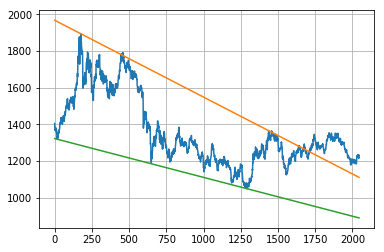

In [24]:
trends, maxlin, minline  = gentrends(gold.Value)

## _Trading Ranges and Trading Range Breakouts_

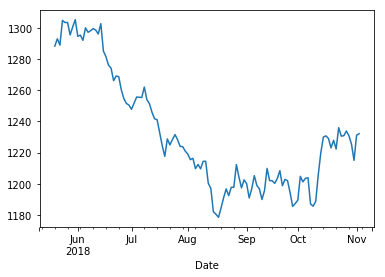

In [39]:
#Define a period
#define a period low
#define a period high
#define a boundary 1-2% around the period low and high
#'draw lines' or create some representation of a boundary  
#define a breakout from the range 
#thrust days
#spike days
#Ndays of highs/lows greater than 3% of boundary values. 
data1 = gold[-120:]
data1_min = data1.min()
data1_max= data1.max()
data1.Value.plot();

## _TD Lines_


In [37]:
#Demark Trendlines
#should be constructed right to left since recent price is more significant
#based exactly two points
#Relative High
#daily high that is higher than the high on the N prior and N succeeding days
#daily Low that is lower than the low on the N prior and N succeeding days
#Prevailing Downtrend Line
    #the line connecting the most recent relative high and the most recent preceding relative high
    #that is also higher than the most recent relative high
#Prevailing uptrend line
    #The line connecting most recent relative low and the most recent preceding relative low
    #that is also lower than the most recent relative low


## _Prior Highs and Lows_

In [38]:
#Define a period
#Define a period high
#Define a period low
#For a preceding period of equal or greater length, define a period high and low

## _Moving Averages_

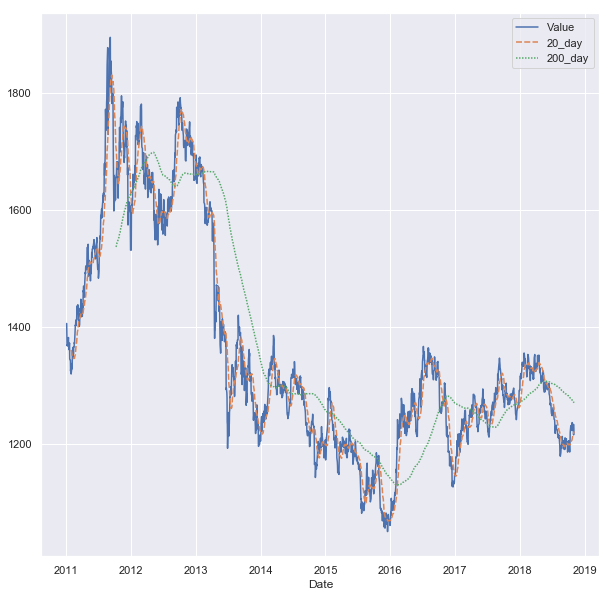

In [73]:
#The main idea is that in a trending market, prices that cross the moving average indicate a shift in trend
#Because there will be many crosses of the moving average we can add a filter of some percentage 
#or even a discrete value as a way to reduce the number of false positives. 


f = plt.figure(figsize=(10,10))
gold['20_day'] = gold.Value.rolling(20).mean()
gold['200_day'] = gold.Value.rolling(200).mean()
sns.set(style="darkgrid")
sns.lineplot(data=gold);

## _Price Envelope Bands_

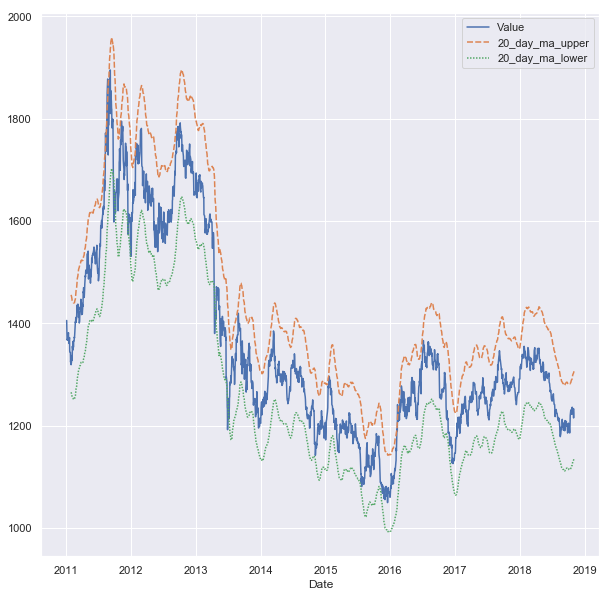

In [78]:
#Price Envelope bands indicate boundaries at which a given instrument
#may be overbought or oversold based on some threshold
#It also serves as a boundary for support and resistance for sideways choppy markets
f = plt.figure(figsize=(10,10))
gold['20_day_ma_upper'] = (gold['20_day'] + gold['20_day']*0.07)
gold['20_day_ma_lower'] = (gold['20_day'] - gold['20_day']*0.07)
gold_bands = gold[['Value', '20_day_ma_upper', '20_day_ma_lower']]
sns.set(style="darkgrid")
sns.lineplot(data=gold_bands);